1. Εισαγωγή απαραίτητων βιβλιοθηκών, σύνδεση Google Drive και αρχικοποίηση περιβάλλοντος Google Earth Engine

In [ ]:
!apt install gdal-bin

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gdal-bin is already the newest version (3.8.4+dfsg-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
!pip install earthengine-api rasterio leafmap localtileserver

In [ ]:
import ee
import time
from google.colab import drive
import numpy as np
import glob
import os
import io
import rasterio
import rasterio.mask
from rasterio.enums import Resampling
import random
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import leafmap.foliumap as leafmap
from pyproj import Transformer
from localtileserver import TileClient, get_folium_tile_layer
import folium
from folium.features import GeoJsonTooltip
from shapely.geometry import mapping, Point
from PIL import Image
import base64
import requests
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
ee.Authenticate()
ee.Initialize(project='sentinel2-datacube')

2. Δημιουργία χρονοσειράς απεικονίσεων Sentinel-2 με συγκεκριμένα κριτήρια (εύρος απεικονίσεων, νεφοκάλυψη κτλ).

In [ ]:
lat, lon = 41.21707219658808, 22.75364377034082 # bounding box center geographic coordinates
max_cloud = 10               # % max cloud cover
time_series_length = 30      # max num of S2 images in the timeseries
pixel_side = 1500            # pixels
resolution = 10              # m/pixel (best S2 resolution)
export_crs = 'EPSG:4326'
start_date = '2024-01-01'
end_date = '2024-12-31'

# Create the bounding box
bbox_m = pixel_side * resolution
dx = bbox_m / 111320
dy = bbox_m / 111320 * np.cos(np.deg2rad(lon))

geometry = ee.Geometry.Rectangle([
    lon - dx/2, lat - dy/2,
    lon + dx/2, lat + dy/2
], proj='EPSG:4326', geodesic=False)

# get the raw coords for the bounding box
region_coords = geometry.getInfo()['coordinates']

# Load Sentinel‑2 SR collection
collection = (
  ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(geometry)
    .filterDate(start_date, end_date)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', max_cloud))
    .limit(time_series_length))

# Show number of collected S2 images for debugging
count = collection.size().getInfo()
print(f"Found {count} images")

# Clip S2 images and compute spectral indices
def process_wrapper(bands):
    def process(img):
        img = img.resample('bilinear').clip(geometry)

        # Cast all bands to Float32 for consistency
        img = img.select(bands).toFloat()

        # Compute indices
        ndvi = img.normalizedDifference(['B8','B4']).toFloat().rename('NDVI')
        ndwi = img.normalizedDifference(['B3','B8']).toFloat().rename('NDWI')
        savi = img.expression(
            '(1 + 0.5) * ((B8 - B4) / (B8 + B4 + 0.5))',
            {
                'B8': img.select('B8'),
                'B4': img.select('B4')
            }
        ).toFloat().rename('SAVI')

        # Return full image with Float32 dtype
        return img.addBands([ndvi, ndwi, savi])
    return process

# List all S2 bands to compute the sperctral indices
bands = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']
processed = collection.map(process_wrapper(bands))

# Export timeseries to Google Drive with a loop
images = processed.toList(count)
tasks = []
acq_dates = []

# Export each cropped image for each date to the drive
for i in range(count):
    img = ee.Image(images.get(i))
    date = ee.Date(img.get('system:time_start')).format('YYYYMMdd').getInfo()
    prefix = f"S2_{date}_{i}"
    task = ee.batch.Export.image.toDrive(
        image=img,
        description=prefix,
        folder="GDBA_Ex3",
        fileNamePrefix=prefix,
        region=region_coords,
        scale=resolution,
        crs=export_crs,
        maxPixels=1e10
    )
    task.start()
    print(f"Export task started: {prefix}")
    tasks.append(task)
    acq_dates.append(date)

# Monitor export status for debug
print("\n Monitoring exports…\n")
for idx, task in enumerate(tasks, 1):
    for _ in range(20):
        st = task.status()
        state = st['state']
        msg = st.get('error_message', '')
        print(f"[{idx}/{count}] {st['description']} → {state} {('- '+msg) if msg else ''}")
        if state in ('COMPLETED', 'FAILED'):
            break
        time.sleep(30)

Found 24 images

 Monitoring exports…



3. Δημιουργία stack όλων των απεικονίσεων.

In [ ]:
tifs_folder = "/content/drive/MyDrive/GDBA_Ex3"

# List all GeoTIFF files in the folder
tif_files = sorted(glob.glob(os.path.join(tifs_folder, "*.tif")))

# Read all the arrays and profiles as well as the per-band metadata
arrays, global_profile = [], None
tags_list, desc_list, nodata_list = [], [], []

for fp in tif_files:
    with rasterio.open(fp) as src:
        arrays.append(src.read())  # read each array with (bands, h, w) shape
        for b in range(1, src.count+1):
            tags_list.append(src.tags(b)) # collect tags
            desc_list.append(src.descriptions[b-1] or "") # collect descriptions
            nodata_list.append(src.nodatavals[b-1]) # collect nodata values

# Stack all the bands in a single array
stacked = np.concatenate(arrays, axis=0)  # final shape = (total_bands, h, w)
total_bands = stacked.shape[0]

# Create a new profile for the stacked array from the first file cloning only
# the necessary fields
with rasterio.open(tif_files[0]) as src0:
    base_profile = {
        'driver': src0.driver,
        'dtype': src0.dtypes[0],
        'count': total_bands,
        'height': src0.height,
        'width': src0.width,
        'crs': src0.crs,
        'transform': src0.transform,
        'nodata': src0.nodatavals[0]
    }

# Write the new array of stacked bands as a .tif file
out_path = os.path.join(tifs_folder, "S2_Timeseries_Stacked.tif")
with rasterio.open(out_path, 'w', **base_profile) as dst:
    dst.write(stacked)
    # Paste the tags/descriptions for all the bands
    for idx in range(1, total_bands+1):
        if tags_list[idx-1]:
            dst.update_tags(idx, **tags_list[idx-1])
        if desc_list[idx-1]:
            dst.set_band_description(idx, desc_list[idx-1])
        if nodata_list[idx-1] is not None:
            dst.update_tags(idx, _FillValue=str(nodata_list[idx-1]))

# Delete from the working folder the initial tif files
for fp in tif_files:
    if "Stacked" not in fp:
      os.remove(fp)

4. Εισαγωγή διανυσματικού αρχείου ορισμού περιοχής μελέτης, μετεωρολογικών στοιχείων (υετός, θερμοκρασία επιφάνειας και υγρασία) και οπτικοποίηση σχημάτων (φασματικά κανάλια Red, Green, Blue και NIR καθώς και δείκτες NDVI, NDWI και savi για 1 τυχαία ημερομηνία από την χρονοσειρά)

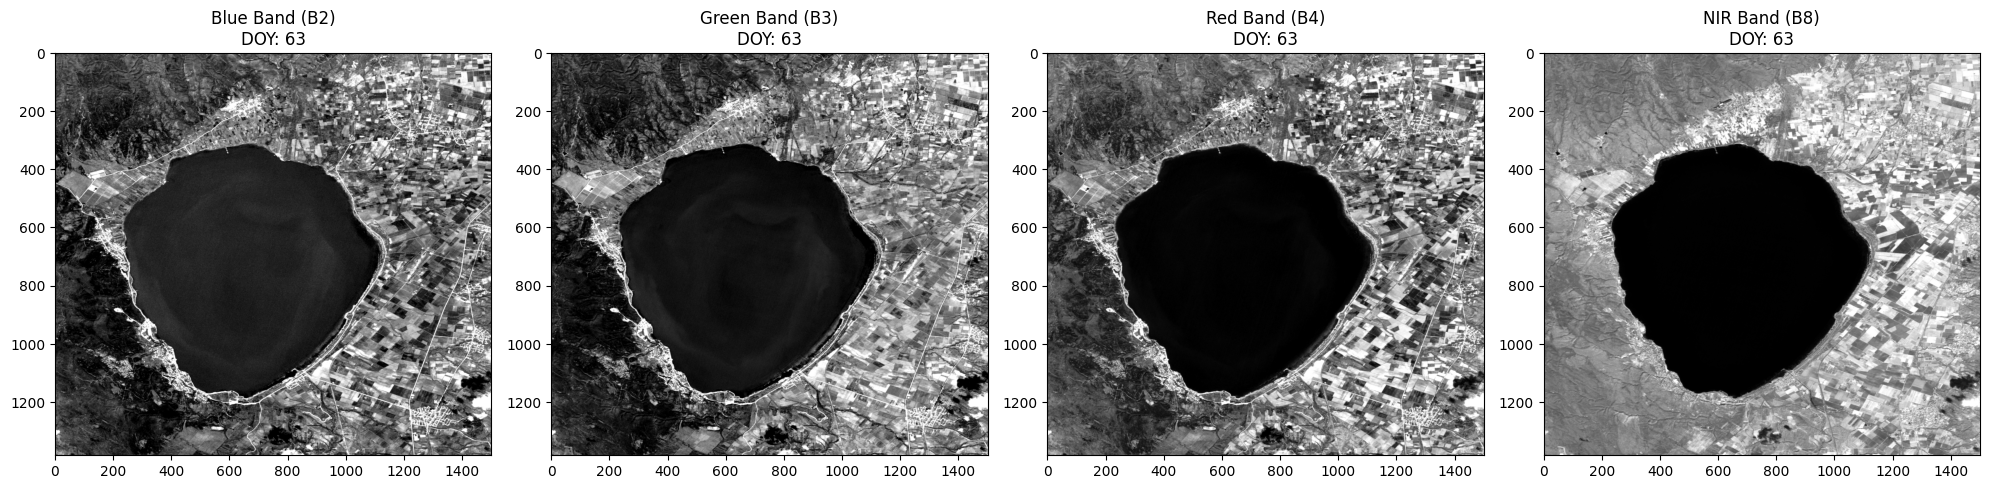

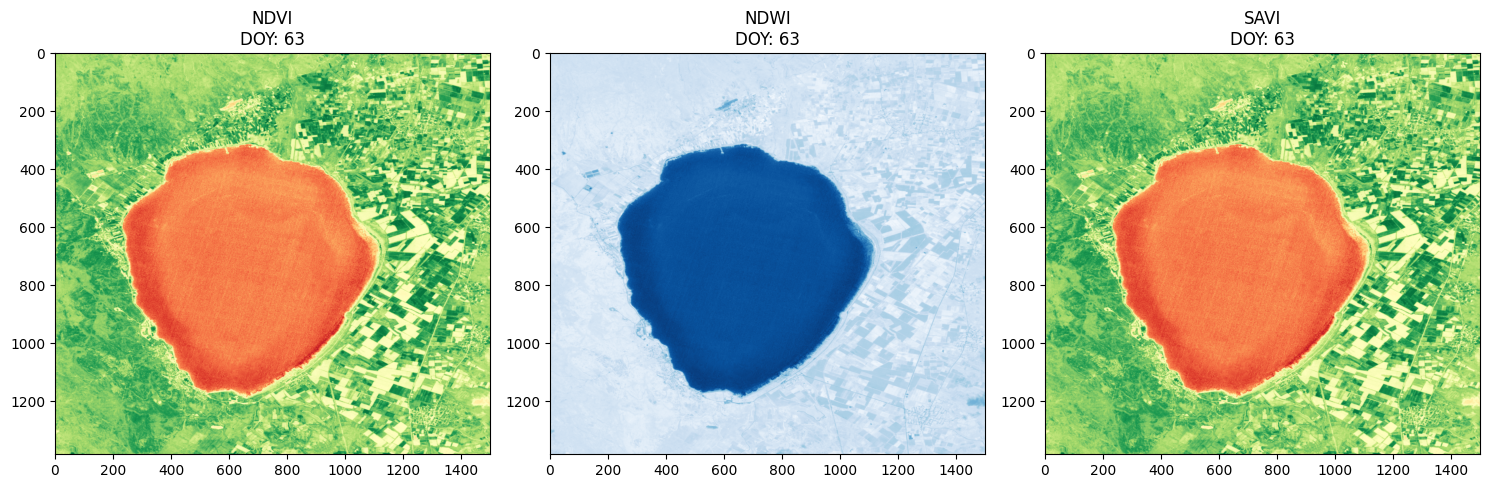

In [ ]:
# convert S2 timeseries acquisition dates to DOY format
dates_doy = [int(acq_date[-2:]) + (int(acq_date[-4:-2])-1) * 30 for acq_date in acq_dates]

# Read the table with meteo data and filter the dates (so that they match with
# the S2 timeseries acquisition dates)
meteo_data = pd.read_csv('/content/drive/MyDrive/GDBA_Ex3/POWER_Point_Daily_20240101_20241231_041d17N_022d75E_LST.csv',
                         skiprows=11)
meteo_filt = meteo_data[meteo_data['DOY'].isin(dates_doy)]

# Read the geojson file with the limits of the area of interest
area_of_interest = gpd.read_file('/content/drive/MyDrive/GDBA_Ex3/AOI.geojson')

# Convert the geo-dataframe to a geo-series object
aoi_series = area_of_interest.geometry

# Select a random DOY+list index from the available timeseries acquisition dates
random_doy = random.choice(dates_doy)
random_index = dates_doy.index(random_doy)

# Create a list with the bands for each S2 image of the timeseries
fbands = bands + ['NDVI', 'NDWI', 'SAVI']
bands_per_im = []

# Update the bands descriptions for consistency
with rasterio.open('/content/drive/MyDrive/GDBA_Ex3/S2_Timeseries_Stacked.tif') as src:
  for i in range(len(dates_doy)):
    bands_per_im.append([])
    iter = i * len(fbands)
    for (j, band), k in zip(enumerate(fbands), range(len(src.descriptions))):
        bands_per_im[i].append(f"Band {1+iter+k}: {band}")

# Plot the blue, red, green and NIR bands from a random S2 image of the timeseries
with rasterio.open('/content/drive/MyDrive/GDBA_Ex3/S2_Timeseries_Stacked.tif') as src:
    # Find the indices of the desired bands for the random image
    blue_idx = random_index * len(fbands) + fbands.index('B2')
    green_idx = random_index * len(fbands) + fbands.index('B3')
    red_idx = random_index * len(fbands) + fbands.index('B4')
    nir_idx = random_index * len(fbands) + fbands.index('B8')

    # Read the band data
    blue_band = src.read(blue_idx + 1) # rasterio is 1-indexed
    green_band = src.read(green_idx + 1)
    red_band = src.read(red_idx + 1)
    nir_band = src.read(nir_idx + 1)

    # Calculate percentiles for contrast enhancement (excluding nodata values if any)
    blue_vmin, blue_vmax = np.nanpercentile(blue_band, (2, 98))
    green_vmin, green_vmax = np.nanpercentile(green_band, (2, 98))
    red_vmin, red_vmax = np.nanpercentile(red_band, (2, 98))
    nir_vmin, nir_vmax = np.nanpercentile(nir_band, (2, 98))

    # Plot the bands with contrast enhancement
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(blue_band, cmap='Greys_r', vmin=blue_vmin, vmax=blue_vmax)
    axes[0].set_title(f'Blue Band (B2)\nDOY: {random_doy}')
    axes[1].imshow(green_band, cmap='Greys_r', vmin=green_vmin, vmax=green_vmax)
    axes[1].set_title(f'Green Band (B3)\nDOY: {random_doy}')
    axes[2].imshow(red_band, cmap='Greys_r', vmin=red_vmin, vmax=red_vmax)
    axes[2].set_title(f'Red Band (B4)\nDOY: {random_doy}')
    axes[3].imshow(nir_band, cmap='Greys_r', vmin=nir_vmin, vmax=nir_vmax) # Use _r for reversed grayscale
    axes[3].set_title(f'NIR Band (B8)\nDOY: {random_doy}')
    plt.tight_layout()
    plt.show()

# Plot the NDVI, NDWI and savi spectral indices for the random S2 image of the timeseries
with rasterio.open('/content/drive/MyDrive/GDBA_Ex3/S2_Timeseries_Stacked.tif') as src:
    # Find the indices of the desired indices for the random image
    ndvi_idx = random_index * len(fbands) + fbands.index('NDVI')
    ndwi_idx = random_index * len(fbands) + fbands.index('NDWI')
    savi_idx = random_index * len(fbands) + fbands.index('SAVI')

    # Read the index data
    ndvi_index = src.read(ndvi_idx + 1) # rasterio is 1-indexed
    ndwi_index = src.read(ndwi_idx + 1)
    savi_index = src.read(savi_idx + 1)

    # Plot the indices
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(ndvi_index, cmap='RdYlGn') # Common colormap for NDVI
    axes[0].set_title(f'NDVI\nDOY: {random_doy}')
    axes[1].imshow(ndwi_index, cmap='Blues') # Common colormap for NDWI
    axes[1].set_title(f'NDWI\nDOY: {random_doy}')
    axes[2].imshow(savi_index, cmap='RdYlGn') # Example colormap for savi
    axes[2].set_title(f'SAVI\nDOY: {random_doy}')
    plt.tight_layout()
    plt.show()

5. Δημιουργία χρονοσειράς μέσου όρου NDVI, NDWI και SAVI για τα εικονοστοιχεία της περιοχής μελέτης.

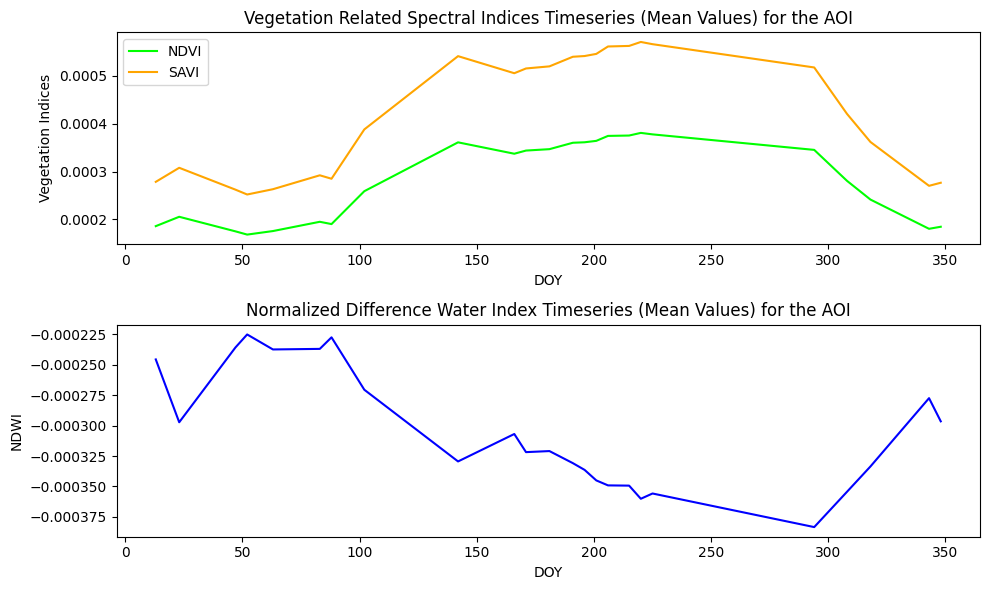

In [ ]:
# List to store the average index values for each image
average_ndvi = []
average_ndwi = []
average_savi = []

# Define the indices for NDVI, NDWI, and savi within each image band list
fbands = bands + ['NDVI', 'NDWI', 'SAVI']
ndvi_band_index_within_image = fbands.index('NDVI')
ndwi_band_index_within_image = fbands.index('NDWI')
savi_band_index_within_image = fbands.index('SAVI')


# Open the stacked GeoTIFF
with rasterio.open('/content/drive/MyDrive/GDBA_Ex3/S2_Timeseries_Stacked.tif') as src:
    # Loop through each image in the time series
    for i in range(len(dates_doy)):
        # Calculate the bands of the spectral indices for the current image
        ndvi_stacked_index = i * len(fbands) + ndvi_band_index_within_image
        ndwi_stacked_index = i * len(fbands) + ndwi_band_index_within_image
        savi_stacked_index = i * len(fbands) + savi_band_index_within_image

        # Read the NDVI, NDWI, and savi bands for the current image
        ndvi_band = src.read(ndvi_stacked_index + 1)
        ndwi_band = src.read(ndwi_stacked_index + 1)
        savi_band = src.read(savi_stacked_index + 1)

        # Mask the bands using the area of interest geometry
        masked_ndvi, _ = rasterio.mask.mask(src, aoi_series, filled=True,
                                            crop=False, indexes=ndvi_stacked_index + 1)
        masked_ndwi, _ = rasterio.mask.mask(src, aoi_series, filled=True,
                                            crop=False, indexes=ndwi_stacked_index + 1)
        masked_savi, _ = rasterio.mask.mask(src, aoi_series, filled=True,
                                             crop=False, indexes=savi_stacked_index + 1)

        # Calculate the mean of the non-masked pixels within the AOI
        # Then use the mask to select only the valid pixels within the AOI
        average_ndvi.append(np.mean(masked_ndvi[masked_ndvi != src.nodata]))
        average_ndwi.append(np.mean(masked_ndwi[masked_ndwi != src.nodata]))
        average_savi.append(np.mean(masked_savi[masked_savi != src.nodata]))

# Create a pandas DataFrame to store the time series data
time_series_df = pd.DataFrame({
    'DOY': dates_doy,
    'NDVI': average_ndvi,
    'NDWI': average_ndwi,
    'SAVI': average_savi
})

# Plot the timeseries for the mean values of the computed spectral indices for
# the areas of interest
fig, ax = plt.subplots(2, 1, figsize=(10,6))
ax[0].set_title('Vegetation Related Spectral Indices Timeseries (Mean Values) for the AOI')
ax[0].set_xlabel('DOY')
ax[0].set_ylabel('Vegetation Indices')
ax[0].plot(time_series_df['DOY'], time_series_df['NDVI'], label='NDVI', color='lime')
ax[0].plot(time_series_df['DOY'], time_series_df['SAVI'], label='SAVI', color='orange')
ax[0].legend(loc='upper left')

ax[1].set_title('Normalized Difference Water Index Timeseries (Mean Values) for the AOI')
ax[1].set_xlabel('DOY')
ax[1].set_ylabel('NDWI')
ax[1].plot(time_series_df['DOY'], time_series_df['NDWI'], label='NDWI', color='blue')
plt.tight_layout()
plt.show()

5. Εισαγωγή επιπλέον δεδομένων vector (πλην των ορίων της περιοχής μελέτης και του σημείου λήψης των μετεωρολογικών δεδομένων) όπως διοικητικά όρια, οδικό/σιδηροδρομικό δίκτυο κ.ο.κ. και οπτικοποιήση τους μαζί με την εξέλιξη των μετεωρολογικών μεταβλητών στον χρόνο.  

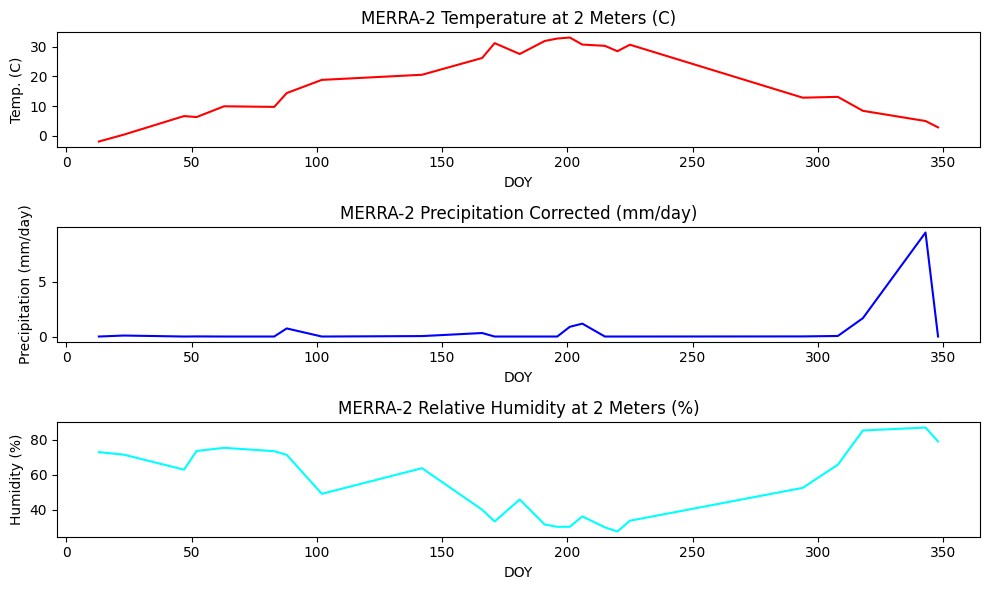

In [ ]:
# Folder containing the shapefiles from Open Street Map
shps_fold = '/content/drive/MyDrive/GDBA_Ex3/Various_Shapefiles/shape'

# Read shapefile paths from the folder
shapefiles = [f for f in os.listdir(shps_fold) if f.endswith('.shp')]

# Initialize a dictionary for storing the vector geometries as geodataframes
gdfs = {}

for shp in shapefiles:
    path = os.path.join(shps_fold, shp)
    gdf = gpd.read_file(path)

    # Remove columns with NULL values
    if not 'places' in shp:
      gdf_cleaned = gdf.dropna(axis=1, how='any')
    else:
      gdf_cleaned = gdf

    # Save the dictionary with the shapefile name as the key
    name = os.path.splitext(shp)[0]
    gdfs[name] = gdf_cleaned

# Plot the timeseries for the mean values of the computed spectral indices for
# the areas of interest
fig, ax = plt.subplots(3, 1, figsize=(10,6))
ax[0].set_title('MERRA-2 Temperature at 2 Meters (C)')
ax[0].set_xlabel('DOY')
ax[0].set_ylabel('Temp. (C)')
ax[0].plot(meteo_filt['DOY'], meteo_filt['T2M'], color='red')

ax[1].set_title('MERRA-2 Precipitation Corrected (mm/day)')
ax[1].set_xlabel('DOY')
ax[1].set_ylabel('Precipitation (mm/day)')
ax[1].plot(meteo_filt['DOY'], meteo_filt['PRECTOTCORR'], color='blue')

ax[2].set_title('MERRA-2 Relative Humidity at 2 Meters (%)')
ax[2].set_xlabel('DOY')
ax[2].set_ylabel('Humidity (%)')
ax[2].plot(meteo_filt['DOY'], meteo_filt['RH2M'], color='cyan')

plt.tight_layout()
plt.show()

6. Δημιουργία διαδραστικού χάρτη με όλα τα raster (έγχρωμα σύνθετα και δείκτες απεικονίσεων χρονοσειράς) και vector δεδομένα που αναπτύχθηκαν στο πλαίσιο της άσκησης.

In [ ]:
# Select a random acquisition date index from the list of acquisition dates
random_index = random.choice(range(len(acq_dates)))
random_date = acq_dates[random_index]
random_doy = dates_doy[random_index]

output_folder = '.' # Export to the working folder

# Open the stacked GeoTIFF
with rasterio.open('/content/drive/MyDrive/GDBA_Ex3/S2_Timeseries_Stacked.tif') as src:
    # Define the indices of the desired bands and indices for the random image
    # The indices are calculated based on the position of the random image in the stacked raster
    # and the position of the band/index within each image's bands
    blue_idx_stacked = random_index * len(fbands) + fbands.index('B2')
    green_idx_stacked = random_index * len(fbands) + fbands.index('B3')
    red_idx_stacked = random_index * len(fbands) + fbands.index('B4')
    nir_idx_stacked = random_index * len(fbands) + fbands.index('B8')
    ndvi_idx_stacked = random_index * len(fbands) + fbands.index('NDVI')
    ndwi_idx_stacked = random_index * len(fbands) + fbands.index('NDWI')
    savi_idx_stacked = random_index * len(fbands) + fbands.index('SAVI')

    # Extract RGB image (bands B4, B3, B2)
    rgb_bands = src.read([red_idx_stacked + 1, green_idx_stacked + 1, blue_idx_stacked + 1])
    rgb_profile = src.meta.copy()
    rgb_profile.update({
        'count': 3,
        'dtype': rgb_bands.dtype,
        'nodata': None
    })
    rgb_output_path = os.path.join(output_folder, f'RGB_{random_date}.tif')
    with rasterio.open(rgb_output_path, 'w', **rgb_profile) as dst:
        dst.write(rgb_bands)
    print(f"Exported RGB image to {rgb_output_path}")

    # Extract NIR-GB false color image (bands B8, B3, B2)
    nirgb_bands = src.read([nir_idx_stacked + 1, green_idx_stacked + 1, blue_idx_stacked + 1])
    nirgb_profile = src.meta.copy()
    nirgb_profile.update({
        'count': 3,
        'dtype': nirgb_bands.dtype,
        'nodata': None
    })

    nirgb_output_path = os.path.join(output_folder, f'NIRGB_{random_date}.tif')
    with rasterio.open(nirgb_output_path, 'w', **nirgb_profile) as dst:
        dst.write(nirgb_bands)
    print(f"Exported NIR-GB image to {nirgb_output_path}")

    # Extract Spectral Indices (NDVI, NDWI, savi)
    ndvi_band = src.read(ndvi_idx_stacked + 1)
    ndwi_band = src.read(ndwi_idx_stacked + 1)
    savi_band = src.read(savi_idx_stacked + 1)
    bands = [ndvi_band, ndwi_band, savi_band]
    band_names = ['NDVI', 'NDWI', 'SAVI']
    band_indices_stacked = [ndvi_idx_stacked, ndwi_idx_stacked, savi_idx_stacked]

    for ind_band, index, stacked_idx in zip(bands, band_names, band_indices_stacked):
        indices_profile = src.meta.copy()
        indices_profile.update({
            'count': 1,
            'dtype': ind_band.dtype,
            'nodata': src.nodata
        })
        output_path = os.path.join(output_folder, f'{index}_Index_{random_date}.tif')
        with rasterio.open(output_path, 'w', **indices_profile) as dst:
            dst.write(ind_band, 1) # Write the single band
            dst.set_band_description(1, index)

        print(f"Exported {index} index to {output_path}")

Exported RGB image to ./RGB_20240222.tif
Exported NIR-GB image to ./NIRGB_20240222.tif
Exported NDVI index to ./NDVI_Index_20240222.tif
Exported NDWI index to ./NDWI_Index_20240222.tif
Exported SAVI index to ./SAVI_Index_20240222.tif


In [ ]:
# Translate RGB natural color image to add it to the folium interactive map
!gdal_translate \
  -of COG \
  -co COMPRESS=LZW \
  -co PREDICTOR=2 \
  -co SPARSE_OK=FALSE \
  -co NUM_THREADS=ALL_CPUS \
  -a_srs EPSG:4326 \
  -scale 0 2189 0 255 \
  /content/RGB_20240222.tif /content/RGB_20240222_translated.tif

# Translate NIR-GB false color image
!gdal_translate \
  -of COG \
  -co COMPRESS=LZW \
  -co PREDICTOR=2 \
  -co SPARSE_OK=FALSE \
  -co NUM_THREADS=ALL_CPUS \
  -a_srs EPSG:4326 \
  -scale 0 4031 0 255 \
  /content/NIRGB_20240222.tif /content/NIRGB_20240222_translated.tif

# Translate each one of the single band spectral indices
!gdal_translate \
  -of COG \
  -co COMPRESS=LZW \
  -co PREDICTOR=2 \
  -co SPARSE_OK=FALSE \
  -co NUM_THREADS=ALL_CPUS \
  -a_srs EPSG:4326 \
  -scale -0.638614 0.886058 0 255 \
  /content/NDVI_Index_20240222.tif /content/NDVI_Index_20240222_translated.tif

!gdal_translate \
-of COG \
-co COMPRESS=LZW \
-co PREDICTOR=2 \
-co SPARSE_OK=FALSE \
-co NUM_THREADS=ALL_CPUS \
-a_srs EPSG:4326 \
-scale -0.803844 0.778846 0 255 \
/content/NDWI_Index_20240222.tif /content/NDWI_Index_20240222_translated.tif

!gdal_translate \
-of COG \
-co COMPRESS=LZW \
-co PREDICTOR=2 \
-co SPARSE_OK=FALSE \
-co NUM_THREADS=ALL_CPUS \
-a_srs EPSG:4326 \
-scale -0.956737 1.328949 0 255 \
/content/SAVI_Index_20240222.tif /content/SAVI_Index_20240222_translated.tif

Input file size is 1501, 1384
0...10...20...30...40...50...60...70...80...90...100 - done.



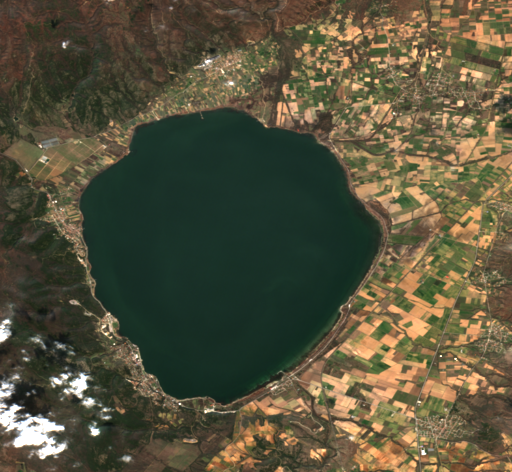
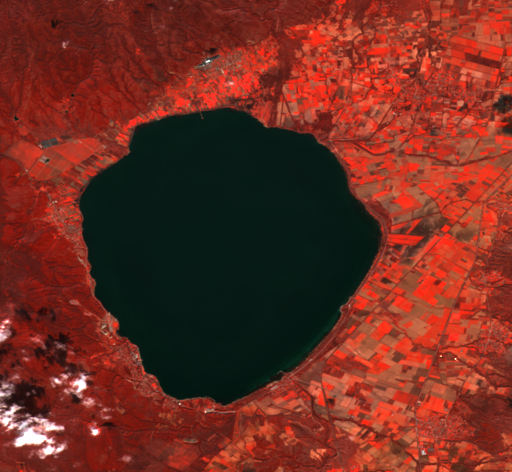
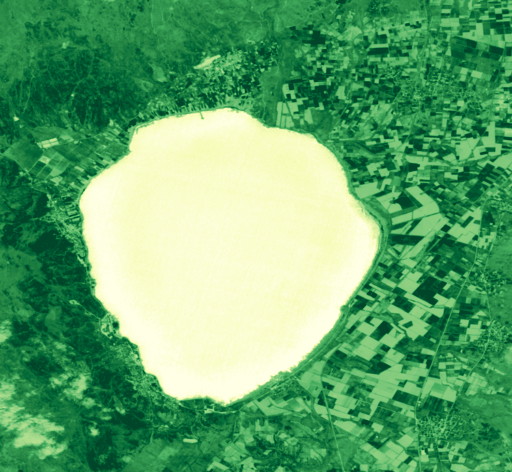
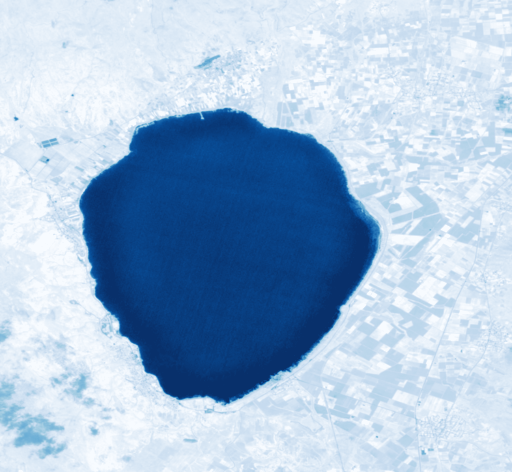
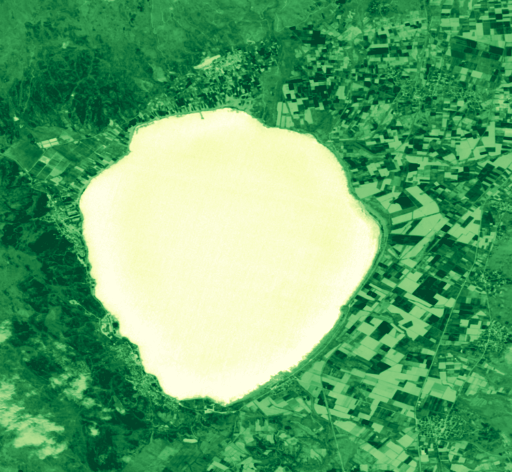

In [ ]:
with rasterio.open("/content/drive/MyDrive/GDBA_Ex3/S2_Timeseries_Stacked.tif") as src:
  bounds = src.bounds
  center_latlon = [(bounds.top + bounds.bottom) / 2, (bounds.right + bounds.left) / 2]

m = folium.Map(location=center_latlon, zoom_start=13, tiles='OpenTopoMap')

# Add AOI polygon to the interactive map
fg_poly = folium.FeatureGroup(name='AOI Polygon', show=True)
folium.GeoJson(
    aoi_series.to_json(),
    style_function=lambda f: {
        'fillColor': 'cyan', 'color': 'blue', 'weight': 2, 'fillOpacity': 0.3
    },
).add_to(fg_poly)
fg_poly.add_to(m)

# 2) Add meteo data acquisition point with a label
pt = Point(22.75, 41.17)  # lon, lat
fg_pt = folium.FeatureGroup(name='Meteo Site', show=True)
folium.Marker(
    location=[41.17, 22.75],
    icon=folium.DivIcon(html="""
      <div style="font-size:12px; color:red; font-weight:bold">
        ● Meteo Data Site
      </div>
    """)
).add_to(fg_pt)
fg_pt.add_to(m)

# Add polygon vector layer with land uses (e.g. agricultural)
lu = gdfs['landuse']
lu_filtered = lu[lu['type'].isin(['residential', 'farmland', 'cemetery', 'military'])]
landuse_colors = {'residential':'gray', 'farmland':'yellow',
                  'cemetery':'purple', 'military':'red'}

for t, grp in lu_filtered.groupby('type'):
    fg = folium.FeatureGroup(name=f'Landuse: {t}')
    folium.GeoJson(
        grp,
        style_function=lambda feature, col=landuse_colors[t]: {
            'fillColor': col, 'color': col, 'weight': 1, 'fillOpacity': 0.5},
        tooltip=GeoJsonTooltip(fields=['type'], aliases=['Landuse Type'])
    ).add_to(fg)
    fg.add_to(m)

# Add polygon vector layer with places of natural interest
fg_nat = folium.FeatureGroup(name='Natural')
folium.GeoJson(
    gdfs['natural'],
    style_function=lambda f: {'color':'green','weight':1},
    tooltip=folium.features.GeoJsonTooltip(fields=['type'])
).add_to(fg_nat)
fg_nat.add_to(m)

# Add places point vector layer with placenames as labels
fg_places = folium.FeatureGroup(name='Places', show=False)
for idx, row in gdfs['places'].iterrows():
    # lat, lon
    y, x = row.geometry.y, row.geometry.x
    name = row.get('name', f'Place {idx}')
    folium.Marker(
        location=[y, x],
        tooltip=name,
        icon=folium.Icon(color='black', icon='info-sign', icon_color='white')
    ).add_to(fg_places)
fg_places.add_to(m)

# Add railways linear vector layer
fg_rail = folium.FeatureGroup(name='Railways')
folium.GeoJson(
    gdfs['railways'],
    style_function=lambda f: {'color':'black','weight':2},
    tooltip=folium.features.GeoJsonTooltip(fields=['type'])
).add_to(fg_rail)
fg_rail.add_to(m)

# Add waterways linear vector layer
fg_water = folium.FeatureGroup(name='Waterways')
folium.GeoJson(
    gdfs['waterways'],
    style_function=lambda f: {'color':'blue','weight':2},
    tooltip=folium.features.GeoJsonTooltip(fields=['type'])
).add_to(fg_water)
fg_water.add_to(m)

# --- Roads με κατηγορίες
road_colors = {'primary':'red','secondary':'orange','tertiary':'yellow',
               'residential':'gray','track':'brown'}
road_widths = {'primary':3,'secondary':2.5,'tertiary':2,
               'residential':1.5,'track':1}

for t, grp in gdfs['roads'].groupby('type'):
    if t in road_colors:
        fg = folium.FeatureGroup(name=f'Road: {t}')
        folium.GeoJson(
            grp,
            style_function=lambda f, c=road_colors[t], w=road_widths[t]: {
                'color': c, 'weight': w},
            tooltip=folium.features.GeoJsonTooltip(fields=['type'])
        ).add_to(fg)
        fg.add_to(m)

def normalize(arr, nodata=None):
    """
    Function for normalizing spectral indices before adding them to the
    interactive map
    Args:
      arr: color composites (3-band images) or spectral indice (1-band image)
      as arrays
      nodata: argument for converting nodata values to NaN
    Returns:
      norm: normalized array
    """
    if nodata is not None:
        arr = arr.astype(float)
        arr[arr == nodata] = np.nan
    lo, hi = np.nanpercentile(arr, (2, 98))
    norm = (arr - lo) / (hi - lo)
    norm = np.clip(norm, 0, 1)
    norm[np.isnan(norm)] = 0
    return norm

def add_overlay(m, path, bands, name, cmap=None, opacity=0.7):
    """
    Function for adding the multi and single band raster images as overlay
    to the basemap of the interactive map environment
    Args:
      path: path to the rasters which will be overlayed
      bands: respective bands of the rasters
      name: string for each raster to be added to the legend of the interactive map
      cmap: colormap for the singleband rasters
      opacity: opacity factor for the raster overlay
    """
    with rasterio.open(path) as src:
        # Downsample to 512x512
        h, w = src.height, src.width
        scale = max(h, w) / 512
        out_h, out_w = int(h/scale), int(w/scale)
        data = src.read(bands, out_shape=(len(bands), out_h, out_w),
                        resampling=rasterio.enums.Resampling.bilinear)

        # Separately for the multiband and singleband rasters, clip the pixel
        # values to (8-bit radiometric resolution)
        if len(bands) == 3:
            arr = np.dstack([data[i] for i in range(3)])
            arr = np.clip(arr, 0, 255).astype(np.uint8)
        else:
            norm = normalize(data[0], nodata=src.nodata)
            cm = cmap(norm)[:, :, :3]
            arr = (cm * 255).astype(np.uint8)

        # Define bounds of the images to be overlayed
        l, b = (src.bounds.left, src.bounds.bottom)
        r, t = (src.bounds.right, src.bounds.top)
        bounds = [[b, l], [t, r]]

        # PNG → data URI
        im = Image.fromarray(arr)
        buf = io.BytesIO(); im.save(buf, 'PNG'); buf.seek(0) # Use io.BytesIO()
        b64 = base64.b64encode(buf.read()).decode()
        data_uri = f'data:image/png;base64,{b64}'

        folium.raster_layers.ImageOverlay(
            image=data_uri,
            bounds=bounds,
            name=name,
            opacity=opacity,
            interactive=True,
            cross_origin=False
        ).add_to(m)

# 2) Paths & cmaps
paths = {
    'RGB': '/content/RGB_20240222_translated.tif',
    'FalseColor': '/content/NIRGB_20240222_translated.tif',
    'NDVI': '/content/NDVI_Index_20240222_translated.tif',
    'NDWI': '/content/NDWI_Index_20240222_translated.tif',
    'SAVI': '/content/SAVI_Index_20240222_translated.tif'
}

cmaps = {
    'NDVI': plt.cm.YlGn,
    'NDWI': plt.cm.Blues,
    'SAVI': plt.cm.YlGn
}

# Add the overlay images to the interactive map
add_overlay(m, paths['RGB'], bands=[1,2,3], name='RGB')
add_overlay(m, paths['FalseColor'], bands=[1,2,3], name='FalseColor')
add_overlay(m, paths['NDVI'], bands=[1], name='NDVI', cmap=cmaps['NDVI'])
add_overlay(m, paths['NDWI'], bands=[1], name='NDWI', cmap=cmaps['NDWI'])
add_overlay(m, paths['SAVI'], bands=[1], name='SAVI', cmap=cmaps['SAVI'])

legend_html = """
<div style="
    position: fixed;
    bottom: 50px; left: 10px; width: 200px; height: auto;
    background: white; border:2px solid grey; z-index:9999; font-size:14px;
    padding: 10px;
">
  <strong>Legend</strong><br>
  <!-- Landuse -->
  <i style="background:gray;opacity:0.7;width:12px;height:12px;display:inline-block"></i>&nbsp; Residential<br>
  <i style="background:yellow;opacity:0.7;width:12px;height:12px;display:inline-block"></i>&nbsp; Farmland<br>
  <i style="background:purple;opacity:0.7;width:12px;height:12px;display:inline-block"></i>&nbsp; Cemetery<br>
  <i style="background:red;opacity:0.7;width:12px;height:12px;display:inline-block"></i>&nbsp; Military<br>
  <hr style="margin:4px 0">
  <!-- Natural -->
  <i style="background:green;opacity:0.7;width:12px;height:12px;display:inline-block"></i>&nbsp; Natural<br>
  <hr style="margin:4px 0">
  <!-- Linear -->
  <i style="color:black;font-weight:bold">—</i>&nbsp; Railways<br>
  <i style="color:blue;font-weight:bold">—</i>&nbsp; Waterways<br>
  <hr style="margin:4px 0">
  <!-- Roads -->
  <i style="color:red;font-weight:bold">—</i>&nbsp; Primary roads<br>
  <i style="color:orange;font-weight:bold">—</i>&nbsp; Secondary roads<br>
  <i style="color:yellow;font-weight:bold">—</i>&nbsp; Tertiary roads<br>
  <i style="color:gray;font-weight:bold">—</i>&nbsp; Residential roads<br>
  <i style="color:brown;font-weight:bold">—</i>&nbsp; Tracks<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Add layer control
folium.LayerControl(collapsed=False).add_to(m)
m